Dataset Overview:

    Person ID Gender  Age            Occupation  Sleep Duration  \
0          1   Male   27     Software Engineer             6.1   
1          2   Male   28                Doctor             6.2   
2          3   Male   28                Doctor             6.2   
3          4   Male   28  Sales Representative             5.9   
4          5   Male   28  Sales Representative             5.9   

   Quality of Sleep  Physical Activity Level  Stress Level BMI Category  \
0                 6                       42             6   Overweight   
1                 6                       60             8       Normal   
2                 6                       60             8       Normal   
3                 4                       30             8        Obese   
4                 4                       30             8        Obese   

  Blood Pressure  Heart Rate  Daily Steps Sleep Disorder  
0         126/83          77         4200            NaN  
1         125/

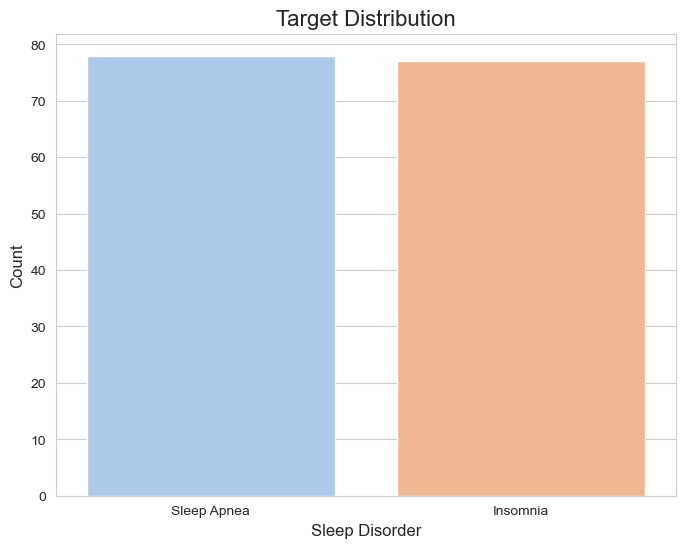

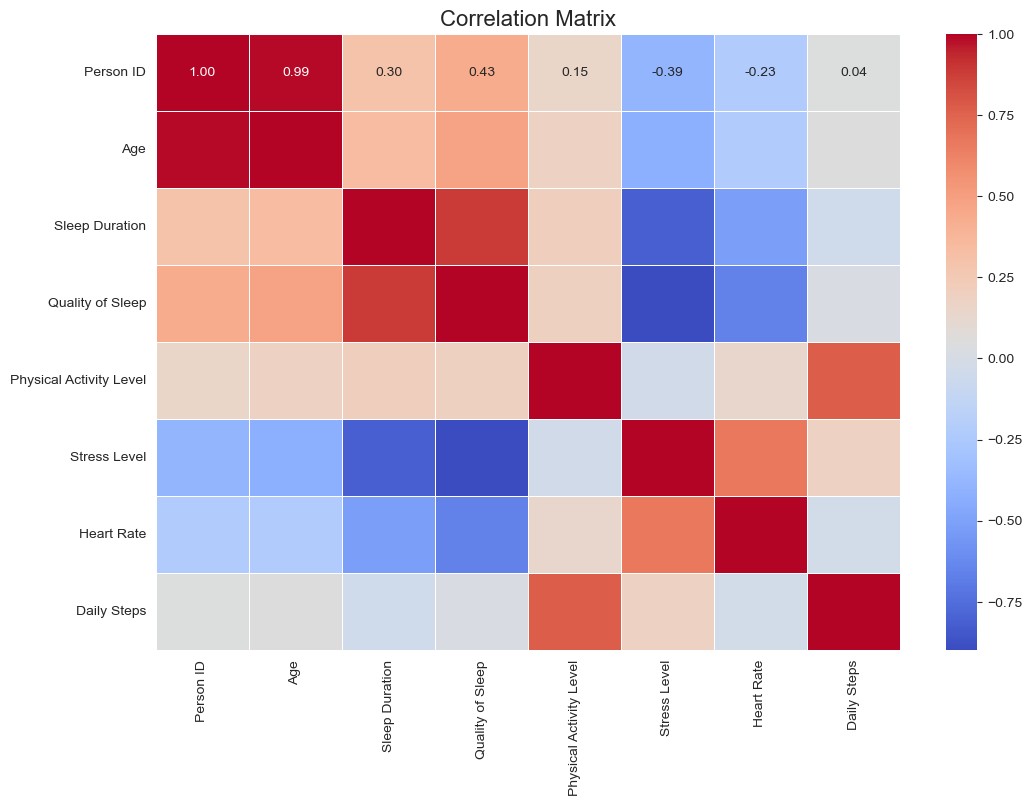

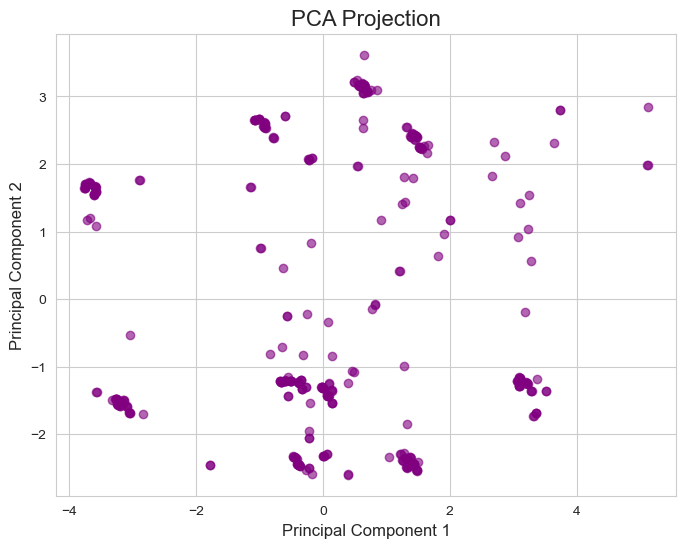

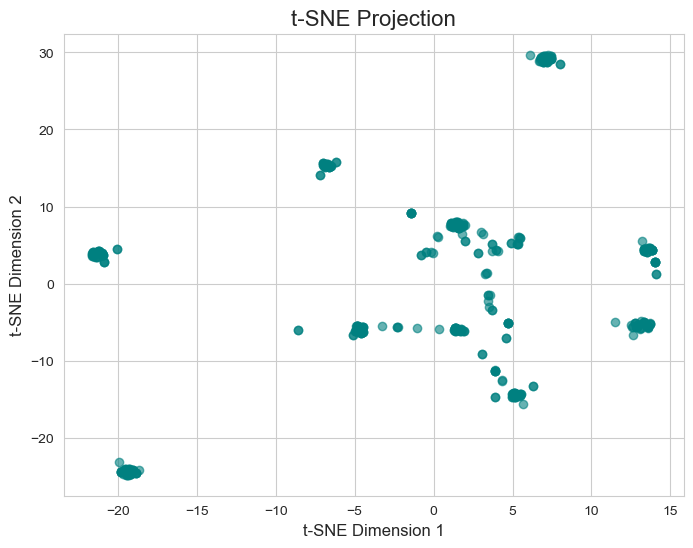

C:\Users\Owner\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


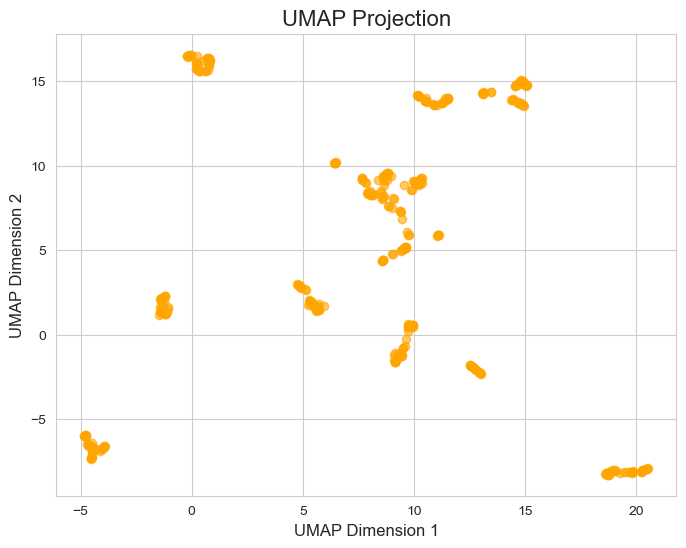

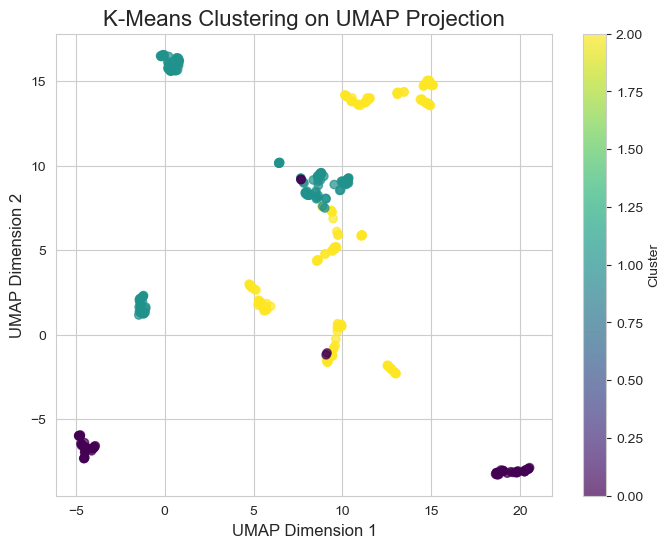


Silhouette Score: 0.37160224269637165

Selected Features:
 Index(['Person ID', 'Age', 'Occupation', 'Sleep Duration',
       'Physical Activity Level', 'Stress Level', 'BMI Category',
       'Blood Pressure', 'Heart Rate', 'Daily Steps'],
      dtype='object')


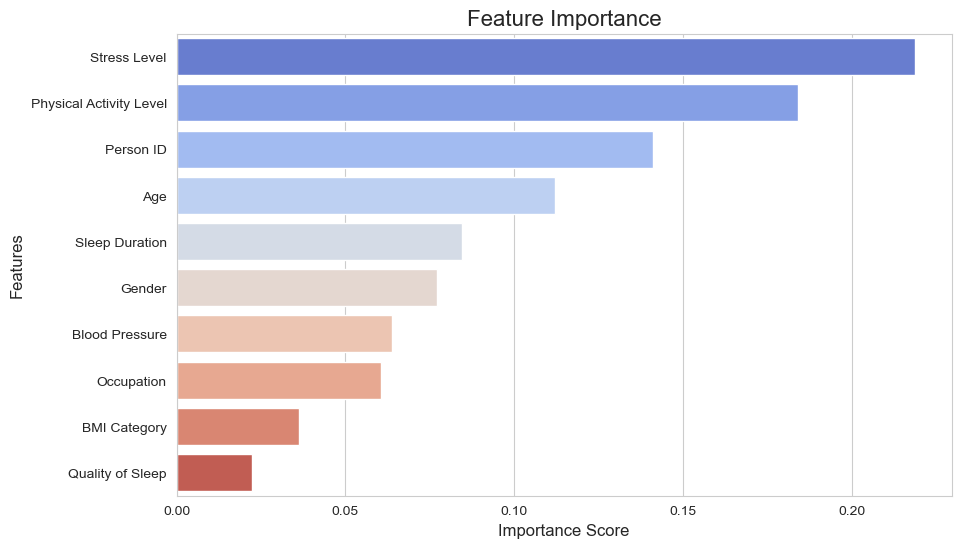


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        44
           1       0.93      0.95      0.94        44
           2       0.95      0.93      0.94        44

    accuracy                           0.95       132
   macro avg       0.95      0.95      0.95       132
weighted avg       0.95      0.95      0.95       132


Confusion Matrix:
 [[42  1  1]
 [ 1 42  1]
 [ 1  2 41]]

Accuracy: 0.946969696969697

Cross-Validation Scores: [0.9047619  0.9047619  0.91428571 0.92380952 0.96190476]

Mean CV Accuracy: 0.921904761904762

Tuned Model Accuracy: 0.9545454545454546

Gradient Boosting Model Accuracy: 0.946969696969697


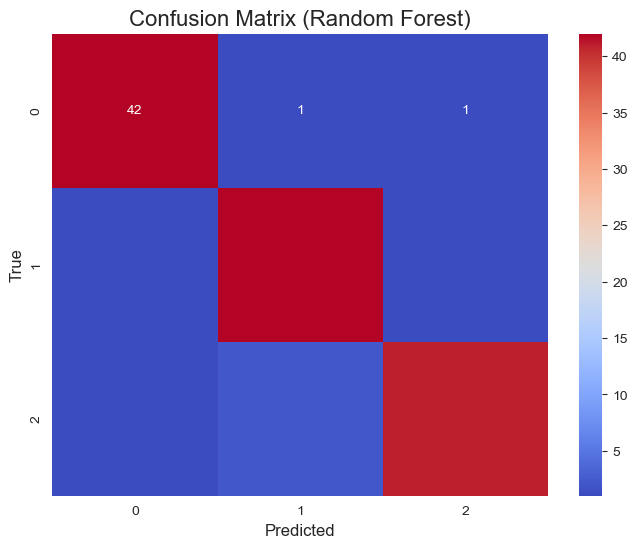

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "2"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, silhouette_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE

# Set global style for Seaborn
sns.set_style("whitegrid")
sns.set_palette("Set2")

# Load Dataset
data = pd.read_csv("Sleep_health_and_lifestyle.csv")  # Replace with the correct file path

# Data Exploration
print("Dataset Overview:\n\n", data.head())
print("\nDataset Info:\n\n")
data.info()
print("\nMissing Values:\n\n", data.isnull().sum())
print("\nSummary Statistics:\n\n", data.describe(include="all"))

# Check Target Distribution
target_column = "Sleep Disorder"  # Replace with your target column
print("\nTarget Distribution:\n", data[target_column].value_counts())

# Visualize Target Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=target_column, data=data, palette="pastel")
plt.title("Target Distribution", fontsize=16)
plt.xlabel("Sleep Disorder", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

# Correlation Plot
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(12, 8))
sns.heatmap(data[numerical_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix", fontsize=16)
plt.show()


# Dimensionality Reduction (PCA, t-SNE, UMAP)
label_encoder = LabelEncoder()
categorical_cols = data.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6, c="purple")
plt.title("PCA Projection", fontsize=16)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.show()

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(data_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.6, c="teal")
plt.title("t-SNE Projection", fontsize=16)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.show()

# UMAP
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)  # Sequential
umap_result = umap_reducer.fit_transform(data_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(umap_result[:, 0], umap_result[:, 1], alpha=0.6, c="orange")
plt.title("UMAP Projection", fontsize=16)
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)
plt.show()

# Unsupervised Learning (Clustering)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(data_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=clusters, cmap="viridis", alpha=0.7)
plt.title("K-Means Clustering on UMAP Projection", fontsize=16)
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)
plt.colorbar(label="Cluster")
plt.show()

score = silhouette_score(data_scaled, clusters)
print(f"\nSilhouette Score: {score}")

# Feature Engineering: Recursive Feature Elimination (RFE)
X = data.drop(target_column, axis=1)
y = label_encoder.fit_transform(data[target_column])
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=10)
X_selected = rfe.fit_transform(X, y)
print("\nSelected Features:\n", X.columns[rfe.support_])

# Balance Classes using SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_selected, y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

# Train a Simple Model (Random Forest)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Feature Importance
importances = rf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[sorted_indices], y=X.columns[sorted_indices], palette="coolwarm")
plt.title("Feature Importance", fontsize=16)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.show()

# Evaluate Model
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nAccuracy:", accuracy_score(y_test, y_pred))

# Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X_train, y_train, cv=skf)
print("\nCross-Validation Scores:", cv_scores)
print("\nMean CV Accuracy:", np.mean(cv_scores))

# Experiment 1: Hyperparameter Tuning (Random Forest)
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring="accuracy")
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
y_pred_tuned = best_rf.predict(X_test)
print("\nTuned Model Accuracy:", accuracy_score(y_test, y_pred_tuned))

# Experiment 2: Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("\nGradient Boosting Model Accuracy:", accuracy_score(y_test, y_pred_gb))

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="coolwarm", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix (Random Forest)", fontsize=16)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.show()